<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/ml-explainability/machine_learning_explainability_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Explainability

## Install dependencies

In [0]:
!pip install -q shap
!pip install -q lime
!pip install -q eli5
!pip install -q --upgrade graphviz
!pip install -q pdpbox

     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 112kB 2.9MB/s 
     |████████████████████████████████| 57.7MB 73kB/s 


## Feature importance

In [0]:
import itertools
import lime
import lime.lime_tabular
import eli5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from eli5.sklearn import PermutationImportance

from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.utils import check_random_state

from pdpbox import pdp
from pdpbox import get_dataset
from pdpbox import info_plots

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


## Load data and train model

In [0]:
SEED = 123
rs = check_random_state(123)
url_prefix = 'https://archive.ics.uci.edu/ml/machine-learning-databases'
data_url = f'{url_prefix}/breast-cancer-wisconsin/wdbc.data'
id_status = ['ID', 'diagnosis']
column_labels = itertools.product(
  ['radius', 'texture', 'perimeter', 'area',
   'smoothness', 'compactness', 'concavity',
   'concave_points', 'symmetry', 'fractal_dim'],
  ['mean','std','max']                       
)
column_labels = id_status + [f'{t}_{f}' for f, t in column_labels]

In [0]:
df = pd.read_csv(data_url, header=None, names=column_labels)
df.head()

,ID,diagnosis,mean_radius,std_radius,max_radius,mean_texture,std_texture,max_texture,mean_perimeter,std_perimeter,max_perimeter,mean_area,std_area,max_area,mean_smoothness,std_smoothness,max_smoothness,mean_compactness,std_compactness,max_compactness,mean_concavity,std_concavity,max_concavity,mean_concave_points,std_concave_points,max_concave_points,mean_symmetry,std_symmetry,max_symmetry,mean_fractal_dim,std_fractal_dim,max_fractal_dim
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
X = df.drop(['ID', 'diagnosis'], axis=1)
y = (df['diagnosis'] == 'M')*1

In [0]:
X.head(3)

,mean_radius,std_radius,max_radius,mean_texture,std_texture,max_texture,mean_perimeter,std_perimeter,max_perimeter,mean_area,std_area,max_area,mean_smoothness,std_smoothness,max_smoothness,mean_compactness,std_compactness,max_compactness,mean_concavity,std_concavity,max_concavity,mean_concave_points,std_concave_points,max_concave_points,mean_symmetry,std_symmetry,max_symmetry,mean_fractal_dim,std_fractal_dim,max_fractal_dim
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [0]:
y.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y,
                                                    random_state=rs)
print(X_train.shape, y_train.shape)
model = RandomForestClassifier(max_depth=4, random_state=rs)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1].tolist()

(426, 30) (426,)


## Evaluate Model

In [0]:
print(f'Test accuracy: {accuracy_score(y_test, y_predict):.2f}')
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predict Benign', 'Predicted Malidnant'],
    index=['Benign', 'Malignant']
)

Test accuracy: 0.96


,Predict Benign,Predicted Malidnant
Benign,86,4
Malignant,2,51


AUC score: 0.9922


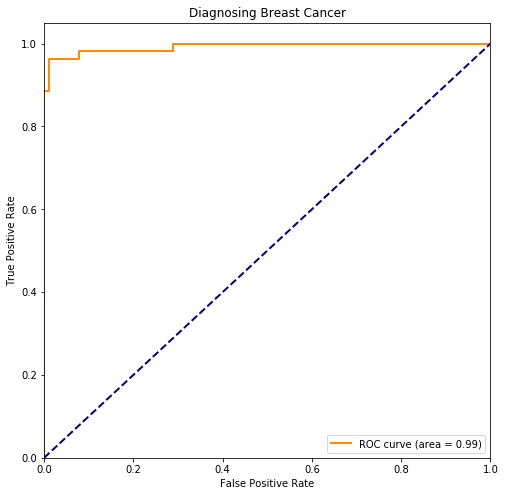

In [0]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f'AUC score: {roc_auc:.4f}')

plt.rcParams['figure.figsize'] = (8,8)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Diagnosing Breast Cancer')
plt.legend(loc='lower right');

## Model-specific feature importance

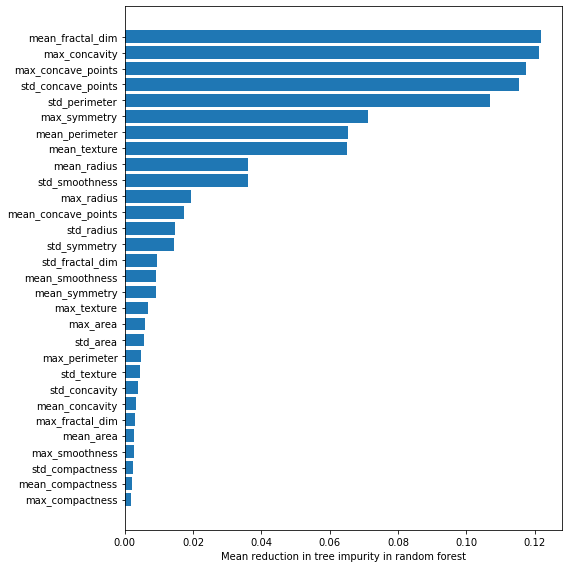

In [0]:
imp_df = pd.DataFrame({
  'feature': X_train.columns,
  'importance': model.feature_importances_   
})

ordered_df = imp_df.sort_values(by='importance')
imp_range = range(1, imp_df.shape[0]+1)

## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in random forest")

plt.tight_layout();

## Permutation feature importance

In [0]:
perm_test = PermutationImportance(model, scoring=make_scorer(roc_auc_score),
                                  n_iter=50, random_state=rs,
                                  cv='prefit')
perm_test.fit(X_train, y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=4,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fract

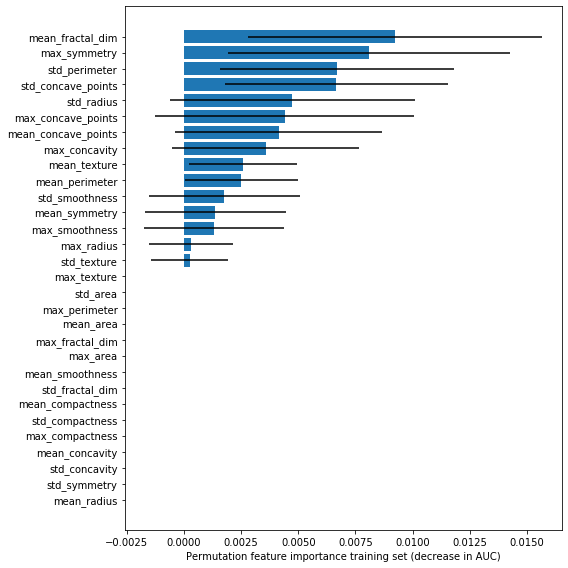

In [0]:
imp_df = eli5.explain_weights_df(perm_test)
label_df = pd.DataFrame({'feature': [ f'x{i}' for i in range(len(X_test.columns))], 'feature_name': X_test.columns.values})
imp_df = pd.merge(label_df, imp_df, on='feature', how='inner', validate='one_to_one')
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='weight')
imp_range=range(1,len(imp_df.index)+1)

height = ordered_df['weight']
bars = ordered_df['feature_name']
ci = 1.96 * ordered_df['std']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, xerr=ci)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Permutation feature importance training set (decrease in AUC)")
plt.tight_layout()

## LIME

In [0]:
X_explain = X_test
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                                   feature_names=X_train.columns.values,
                                                   discretize_continuous=True,
                                                   class_names=['benign', 'malign'],
                                                   mode='classification',
                                                   verbose=True,
                                                   random_state=rs)

exp = explainer.explain_instance(X_explain.values[0,:], 
                                 model.predict_proba,
                                 num_features=30)

Intercept 0.25993818253706014
Prediction_local [0.78137953]
Right: 0.9868871542416519


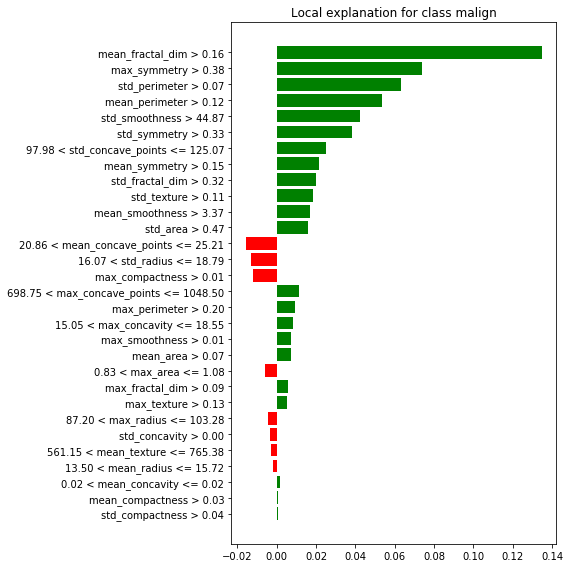

In [0]:
plt = exp.as_pyplot_figure()
plt.tight_layout()
#exp.show_in_notebook(show_table=True);

## New York City Taxi Fare Prediction

In [0]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c new-york-city-taxi-fare-prediction
!ls -l /content
!unzip -o train.csv.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
100% 1.56G/1.56G [00:14<00:00, 101MB/s]
100% 1.56G/1.56G [00:14<00:00, 116MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 117MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 99.5MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 440kB/s]
total 1636424
-rw-r--r-- 1 root root        486 Feb  6 17:33 GCP-Coupons-Instructions.rtf
drwx------ 4 root root       4096 Feb  6 17:33 gdrive
drwxr-xr-x 1 root root       4096 

In [0]:
data = pd.read_csv('train.csv', nrows=50000)
data.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2


Remove data with extreme outlier coordinates or negative fares

In [0]:
data = data.query(
    'pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
    'dropoff_latitude > 40.7 and dropoff_latitude <40.8 and ' +
    'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
    'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
    'fare_amount > 0'
)

In [0]:
data.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
data.shape

(31289, 8)

In [0]:
y = data.fare_amount
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'passenger_count']
X = data[base_features]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=50, random_state=1)
first_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [0]:
X_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,23466.000000,23466.000000,23466.000000,23466.000000,23466.000000
mean,-73.976827,40.756931,-73.975359,40.757434,1.662320
std,0.014625,0.018206,0.015930,0.018659,1.290729
min,-73.999999,40.700013,-73.999999,40.700020,0.000000
25%,-73.987964,40.744901,-73.987143,40.745756,1.000000
50%,-73.979629,40.758076,-73.978588,40.758542,1.000000
75%,-73.967797,40.769602,-73.966459,40.770406,2.000000
max,-73.900062,40.799952,-73.900062,40.799999,6.000000


In [0]:
y_train.describe()

count    23466.000000
mean         8.472539
std          4.609747
min          0.010000
25%          5.500000
50%          7.500000
75%         10.100000
max        165.000000
Name: fare_amount, dtype: float64

In [0]:
y_pred = first_model.predict(X_test)

rmse_score = mean_squared_error(y_test, y_pred)**(1/2) 
print(f'acc_score: {rmse_score:.4f}')

acc_score: 3.5673


## Permutation Importance

In [0]:
perm = PermutationImportance(first_model, random_state=1)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.to_list())

Weight,Feature
0.8387 ± 0.0168,dropoff_latitude
0.8326 ± 0.0212,pickup_latitude
0.5947 ± 0.0432,pickup_longitude
0.5326 ± 0.0275,dropoff_longitude
-0.0022 ± 0.0014,passenger_count


In [0]:
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2 = [
  'pickup_longitude',
  'pickup_latitude',
  'dropoff_longitude',
  'dropoff_latitude',
  'abs_lat_change',
  'abs_lon_change'
]
X = data[features_2]
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1)
second_model.fit(new_X_train, new_y_train)

perm2 = PermutationImportance(second_model, random_state=1)
perm2.fit(new_X_test, new_y_test)
eli5.show_weights(perm2, feature_names=features_2)

Weight,Feature
0.5786 ± 0.0294,abs_lat_change
0.4469 ± 0.0509,abs_lon_change
0.0860 ± 0.0334,pickup_latitude
0.0735 ± 0.0114,dropoff_latitude
0.0735 ± 0.0101,dropoff_longitude
0.0609 ± 0.0067,pickup_longitude


In [0]:
data[['abs_lon_change', 'abs_lat_change']].describe()

,abs_lon_change,abs_lat_change
count,31289.000000,31289.000000
mean,0.013039,0.014893
std,0.011644,0.012234
min,0.000000,0.000000
25%,0.004947,0.006038
50%,0.010049,0.011670
75%,0.017717,0.020497
max,0.094065,0.094655


In [0]:
data[['pickup_longitude', 'pickup_latitude']].describe()

,pickup_longitude,pickup_latitude
count,31289.000000,31289.000000
mean,-73.976860,40.756917
std,0.014635,0.018170
min,-73.999999,40.700013
25%,-73.988039,40.744947
50%,-73.979691,40.758027
75%,-73.967823,40.769580
max,-73.900062,40.799952


## Partial Dependence Plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


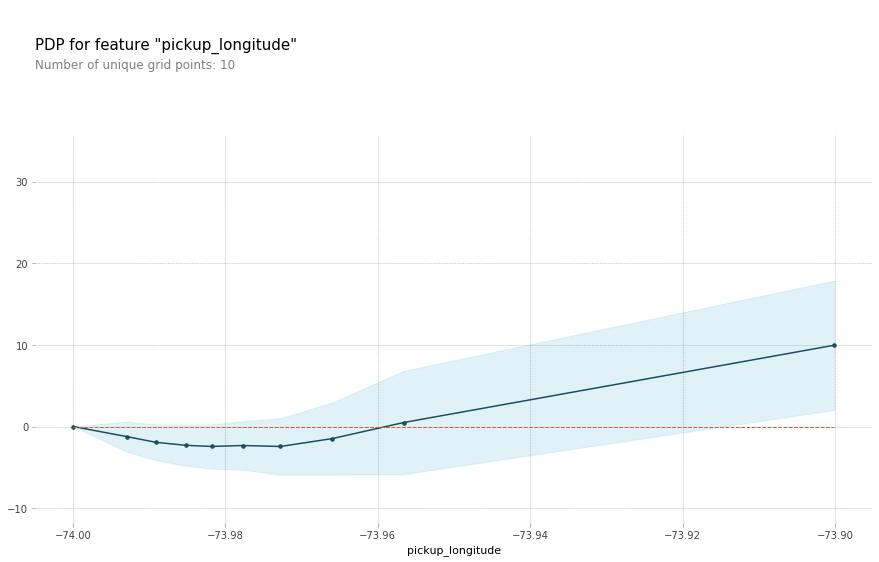

In [0]:
feat_name= 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=first_model, dataset=X_test,
                           model_features=base_features, 
                           feature=feat_name)
pdp.pdp_plot(pdp_dist, feat_name)
plt.show();

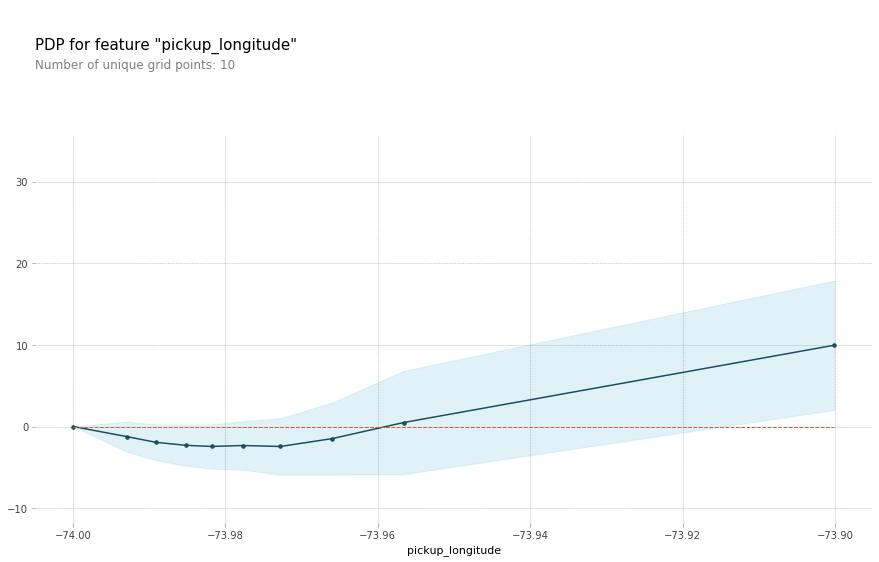

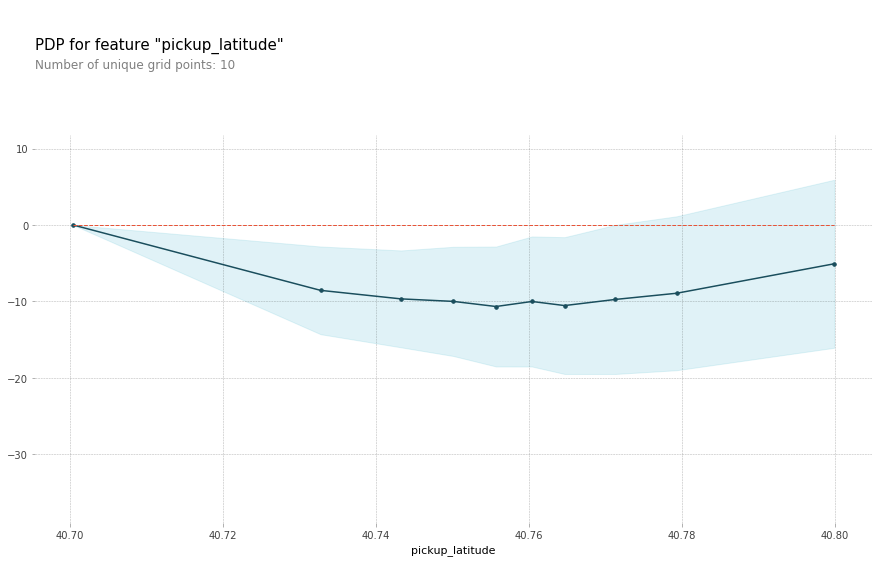

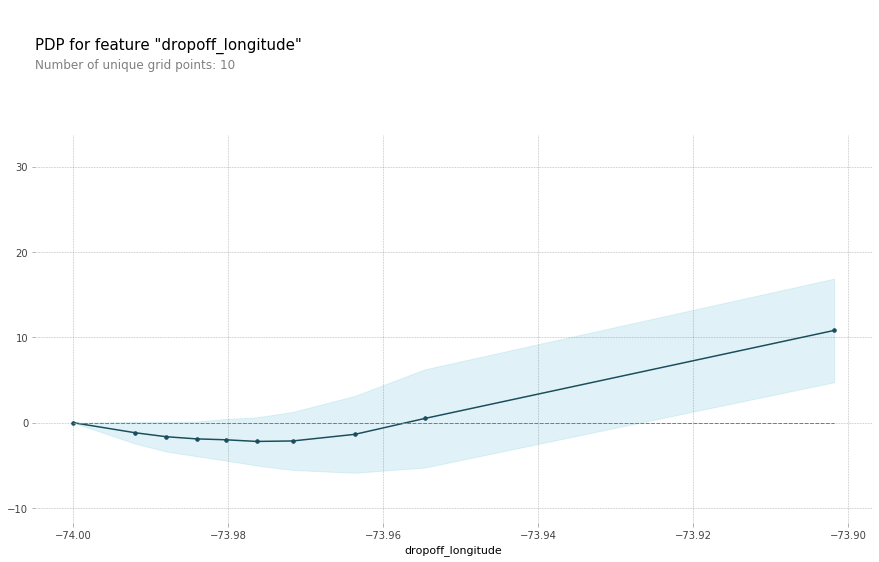

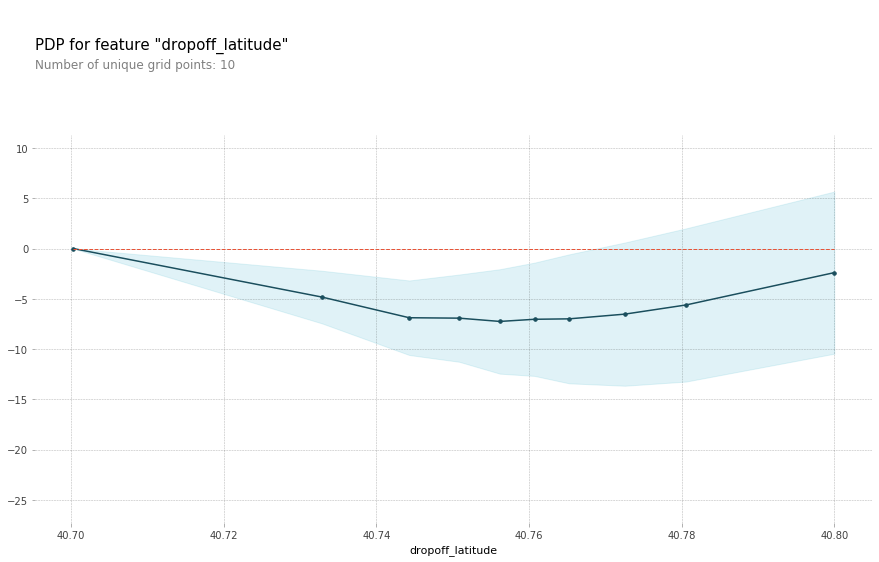

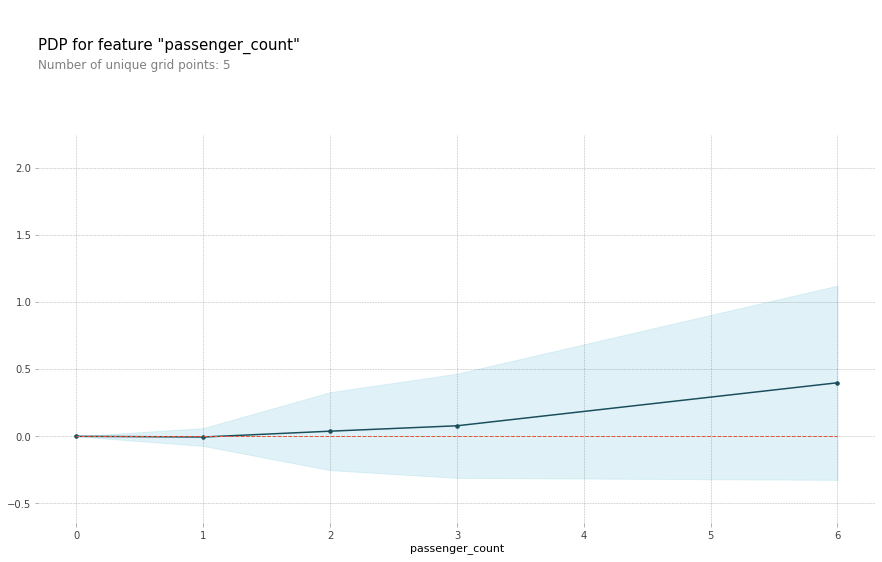

In [0]:
for feat_name in base_features:
    pdp_dist = pdp.pdp_isolate(model=first_model, dataset=X_test,
                           model_features=base_features, 
                           feature=feat_name)
    pdp.pdp_plot(pdp_dist, feat_name);

TypeError: ignored

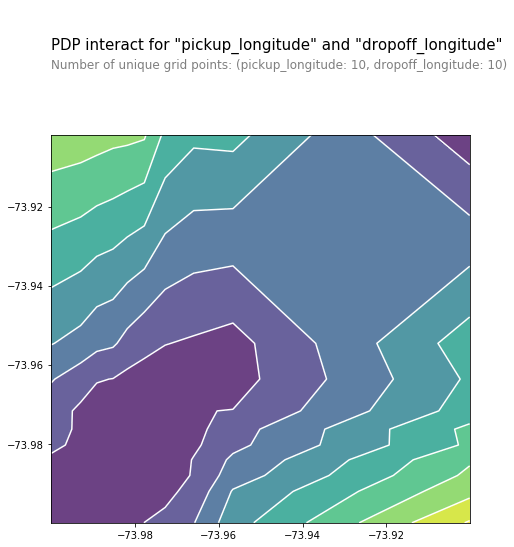

In [0]:
fnames = ['pickup_longitude', 'dropoff_longitude']
longitudes_partial_plot =  pdp.pdp_interact(model=first_model, dataset=X_test, model_features=base_features, features=fnames)
pdp.pdp_interact_plot(pdp_interact_out=longitudes_partial_plot, feature_names=fnames, plot_type='contour');

## Medical Data and Hospital Readmissions

### Download Dataset

In [0]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dansbecker/hospital-readmissions
!ls -l /content
!unzip -o hospital-readmissions.zip -d ./medical-data-hospital-readmissions

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
hospital-readmissions.zip: Skipping, found more recently modified local copy (use --force to force download)
total 7200608
-rw-r--r-- 1 root root        486 Feb  6 17:33 GCP-Coupons-Instructions.rtf
drwx------ 4 root root       4096 Feb  6 17:33 gdrive
-rw-r--r-- 1 root root     534254 Feb  6 17:37 hospital-readmissions.zip
drwxr-xr-x 2 root root       4096 Feb  6 17:51 medical-data-hospital-readmissions
drwxr-xr-x 1 root root       4096 Jan 30 17:25 sample_data
-rw-r--r-- 1 root root     343271 Feb  6 17:33 sample_submission.csv
-rw-r--r-- 1 root root     983020 Feb  6 17:33 test.csv
-rw-r--r-- 1 root root 5697178298 Dec 12 00:18 train.csv
-rw-r--r-- 1 root root 1674351608 Feb  6 17:33 train.csv.zip
Archive:  hospital-readmissions.zip
  inflating: ./medical-data-hospital-readmissions/train.csv  


## Baseline Model

In [0]:
data = pd.read_csv('./medical-data-hospital-readmissions/train.csv')

X = data.drop(['readmitted'], axis=1)
y = data['readmitted']

base_features = X.columns.to_list()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
med_model = RandomForestClassifier(n_estimators=30, random_state=1)
med_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

## Permutation importance

In [0]:
perm = PermutationImportance(med_model, random_state=1)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=base_features)

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


In [0]:
X_train.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000,18750.000000
mean,4.400053,42.989387,1.340427,16.007040,0.365813,0.200587,0.647893,7.430453
std,2.998962,19.763168,1.711124,8.161855,1.228449,0.979239,1.267038,1.941801
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,109.000000,6.000000,81.000000,36.000000,64.000000,21.000000,16.000000


In [0]:
X_train.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_Caucasian',
       'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)',
       'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?',
       'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC',
       'medical_specialty_?', 'medical_specialty_InternalMedicine',
       'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414',
       'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427',
       'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428',
       'max_glu_serum_None', 'A1Cresult_None', 'metformin_No',
       'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No',
       'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No',
     

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(med_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0451 ± 0.0068,number_inpatient
0.0087 ± 0.0046,number_emergency
0.0062 ± 0.0053,number_outpatient
0.0033 ± 0.0016,payer_code_MC
0.0020 ± 0.0016,diag_3_401
0.0016 ± 0.0031,medical_specialty_Emergency/Trauma
0.0014 ± 0.0024,A1Cresult_None
0.0014 ± 0.0021,medical_specialty_Family/GeneralPractice
0.0013 ± 0.0010,diag_2_427
0.0013 ± 0.0011,diag_2_276


## Partial dependence plot

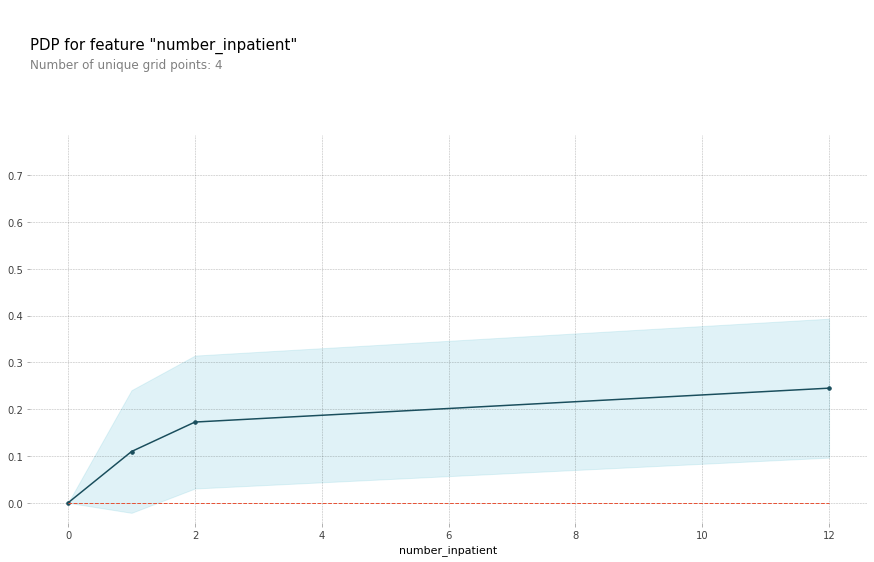

In [0]:
# Create the data that we will plot
pdp_num_inpatient = pdp.pdp_isolate(model=med_model, dataset=X_test, 
                            model_features=base_features, 
                            feature='number_inpatient')

# plot it
pdp.pdp_plot(pdp_num_inpatient, 'number_inpatient');

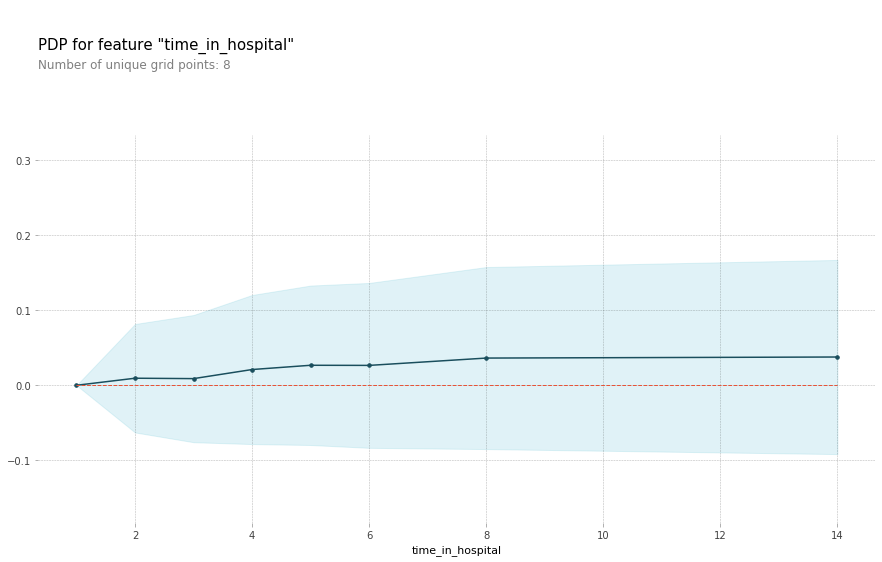

In [0]:
feature_name = 'time_in_hospital'
# Create the data that we will plot
my_pdp = pdp.pdp_isolate(model=med_model, dataset=X_test, 
                         model_features=X_test.columns, 
                         feature=feature_name)

# plot it
pdp.pdp_plot(my_pdp, feature_name)
plt.show()

In [0]:
data_for_prediction = X_test.iloc[0,:]  # use 1 row of data here. Could use multiple rows if desired

# Create object that can calculate shap values
explainer = shap.TreeExplainer(med_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

## FIFA 2018 Worldcup - Man of the Match

### Download dataset

In [0]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mathan/fifa-2018-match-statistics
!ls -l /content
!unzip -o fifa-2018-match-statistics.zip -d ./fifa-data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
  0% 0.00/3.86k [00:00<?, ?B/s]
100% 3.86k/3.86k [00:00<00:00, 3.44MB/s]
total 12
-rw-r--r-- 1 root root 3952 Feb  7 19:59 fifa-2018-match-statistics.zip
drwx------ 4 root root 4096 Feb  7 19:59 gdrive
drwxr-xr-x 1 root root 4096 Feb  5 18:37 sample_data
Archive:  fifa-2018-match-statistics.zip
  inflating: ./fifa-data/FIFA 2018 Statistics.csv  


## Baseline Model

In [0]:
rng = np.random.RandomState(seed=42)
data = pd.read_csv('./fifa-data/FIFA 2018 Statistics.csv')

categorical_columns = ['Team', 'Opponent', 'Round']
numerical_columns = ['Goal Scored', 'Ball Possession %', 'Attempts',
                     'On-Target', 'Off-Target', 'Blocked', 'Corners',
                     'Offsides', 'Free Kicks', 'Saves', 'Pass Accuracy %',
                     'Passes', 'Distance Covered (Kms)', 'Fouls Committed',
                     'Yellow Card', 'Yellow & Red', 'Red', 'PSO',
                     'Goals in PSO']

data['PSO'] = (data['PSO'] == 'Yes')*1
X = data([categorical_columns + numerical_columns])
y = (data['Man of the Match'] == 'Yes')

base_features = X.columns.to_list()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

categorical_pipe = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))                             
])

numerical_pipe = Pipeline([
  ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

preprocessing = ColumTransformer([
  ('cat', categorical_pipe, categorical_columns),
  ('num', numerical_pipe, numerical_columns),
])

fifa_classifier = RandomForestClassifier(n_estimators=30, random_state=1)

fifa_rf = Pipeline([
                    
])

In [0]:
data.columns

Index(['Team', 'Opponent', 'Goal Scored', 'Ball Possession %', 'Attempts',
       'On-Target', 'Off-Target', 'Blocked', 'Corners', 'Offsides',
       'Free Kicks', 'Saves', 'Pass Accuracy %', 'Passes',
       'Distance Covered (Kms)', 'Fouls Committed', 'Yellow Card',
       'Yellow & Red', 'Red', 'Man of the Match', '1st Goal', 'Round', 'PSO',
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')

In [0]:
data.head(3)

,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,Russia,Saudi Arabia,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,Yes,12.0,Group Stage,0,0,NaN,NaN
1,Saudi Arabia,Russia,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,No,NaN,Group Stage,0,0,NaN,NaN
2,Egypt,Uruguay,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,No,NaN,Group Stage,0,0,NaN,NaN


In [0]:
data['Own goals'].value_counts()

1.0    12
Name: Own goals, dtype: int64

In [0]:
data.shape

(128, 26)

In [0]:
data['Own goal Time'].value_counts()

90.0    2
18.0    1
13.0    1
12.0    1
33.0    1
74.0    1
23.0    1
47.0    1
37.0    1
32.0    1
81.0    1
Name: Own goal Time, dtype: int64